In [1]:
from google.colab import files
uploaded = files.upload()

Saving dogcat.zip to dogcat.zip


In [8]:
import zipfile
with zipfile.ZipFile('/content/dogcat.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [14]:
import os
import shutil
from sklearn.model_selection import train_test_split


# Define paths
train_dir = '/content/training_set/training_set'
test_dir = '/content/test_set/test_set'
validation_dir = '/content/validation1'

# Create validation directory
if not os.path.exists(validation_dir):
    os.makedirs(validation_dir)


# Split train directory into training and validation sets
train_classes = ['dogs', 'cats']  # Specify class names


for class_name in train_classes:
    class_train_dir = os.path.join(train_dir, class_name)
    class_validation_dir = os.path.join(validation_dir, class_name)

    # Create class directory in validation set
    if not os.path.exists(class_validation_dir):
        os.makedirs(class_validation_dir)

    # Get image file names
    image_file_names = os.listdir(class_train_dir)

    # Split image file names into training and validation sets
    train_image_file_names, validation_image_file_names = train_test_split(image_file_names, test_size=0.2, random_state=42)

    # Move validation images to validation directory
    for image_file_name in validation_image_file_names:
        image_file_path = os.path.join(class_train_dir, image_file_name)
        destination_path = os.path.join(class_validation_dir, image_file_name)
        shutil.move(image_file_path, destination_path)


print("Train, validation, and test directories are ready.")

Train, validation, and test directories are ready.


In [19]:
# Import necessary libraries
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
TRAIN_DIR = '/content/training_set/training_set'
VALIDATION_DIR = '/content/validation1'
TEST_DIR = '/content/test_set/test_set'


# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# Load and split data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


# Load VGG19 model with pre-trained weights
def load_base_model():
    return VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))


# Freeze base model layers
def freeze_base_model_layers(base_model):
    for layer in base_model.layers:
        layer.trainable = False


# Add custom layers
def add_custom_layers(base_model):
    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Dense(1, activation='sigmoid')(x)


# Define new model
def define_model(base_model):
    predictions = add_custom_layers(base_model)
    return Model(inputs=base_model.input, outputs=predictions)


# Compile model
def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# Train model
def train_model(model, train_generator, validation_generator):
    return model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        epochs=5
    )


# Evaluate model
def evaluate_model(model, test_generator):
    return model.evaluate(test_generator)


# Print classification report and confusion matrix
def print_classification_report(model, test_generator):
    y_pred = model.predict(test_generator)
    y_pred_class = np.round(y_pred)
    print(classification_report(test_generator.classes, y_pred_class))
    print(confusion_matrix(test_generator.classes, y_pred_class))


# Main function
def main():
    base_model = load_base_model()
    freeze_base_model_layers(base_model)
    model = define_model(base_model)
    compile_model(model)
    history = train_model(model, train_generator, validation_generator)
    loss, accuracy = evaluate_model(model, test_generator)
    print(f'Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')
    print_classification_report(model, test_generator)


if __name__ == "__main__":
    main()

Found 5121 images belonging to 2 classes.
Found 1281 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 60s 350ms/step - accuracy: 0.7383 - loss: 1.0684 - val_accuracy: 0.8656 - val_loss: 0.3093
Epoch 2/5
  1/160 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.8750 - loss: 0.2394

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.2394 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 3/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 57s 343ms/step - accuracy: 0.8936 - loss: 0.2488 - val_accuracy: 0.9062 - val_loss: 0.2246
Epoch 4/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 107us/step - accuracy: 0.9375 - loss: 0.1449 - val_accuracy: 1.0000 - val_loss: 0.0137
Epoch 5/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 57s 341ms/step - accuracy: 0.9140 - loss: 0.2151 - val_accuracy: 0.9031 - val_loss: 0.2172
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.8913 - loss: 0.2280
Test loss: 0.217, Test accuracy: 0.904
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step
              precision    recall  f1-score   support

           0       0.49      0.47      0.48      1011
           1       0.49      0.52      0.50      1012

    accuracy                           0.49      2023
   macro avg       0.49      0.49      0.49      2023
weighted avg       0.49      0.49      0.49      2023

[[477 534]
 [4

Found 5121 images belonging to 2 classes.
Found 1281 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 60s 345ms/step - accuracy: 0.7262 - loss: 0.9298 - val_accuracy: 0.8258 - val_loss: 0.4204
Epoch 2/10
  1/160 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.7500 - loss: 0.4637

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.4637 - val_accuracy: 1.0000 - val_loss: 0.1698
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 57s 340ms/step - accuracy: 0.8817 - loss: 0.2617 - val_accuracy: 0.8789 - val_loss: 0.2942
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 112us/step - accuracy: 0.8438 - loss: 0.3522 - val_accuracy: 1.0000 - val_loss: 0.0305
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 57s 341ms/step - accuracy: 0.9143 - loss: 0.2048 - val_accuracy: 0.8781 - val_loss: 0.3319
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 103us/step - accuracy: 0.8750 - loss: 0.3766 - val_accuracy: 1.0000 - val_loss: 3.2033e-04
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 57s 342ms/step - accuracy: 0.9262 - loss: 0.1974 - val_accuracy: 0.8867 - val_loss: 0.2717
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 105us/step - accuracy: 0.9375 - loss: 0.1231 - val_accuracy: 1.0000 - val_loss: 8.9324e-04
Epoch 9/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 57s 341ms/step - accuracy: 0.9211 - loss: 0.1857 - v

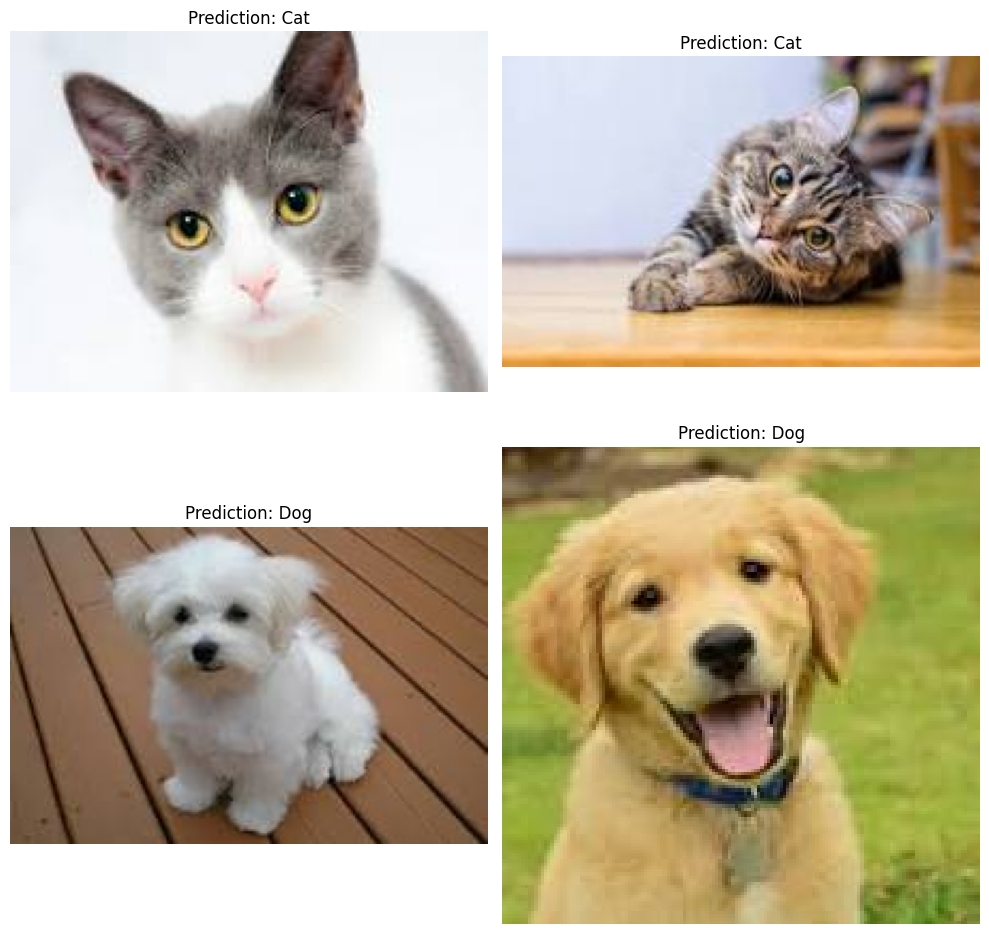

In [21]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam


# Define constants
IMAGE_SIZE = (224, 224)
TRAIN_DIR = '/content/training_set/training_set'
VALIDATION_DIR = '/content/validation1'
TEST_DIR = '/content/test_set/test_set'


# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# Load and split data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='binary'
)


# Load VGG19 model with pre-trained weights
def load_base_model():
    return VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))


# Freeze base model layers
def freeze_base_model_layers(base_model):
    for layer in base_model.layers:
        layer.trainable = False


# Add custom layers
def add_custom_layers(base_model):
    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Dense(1, activation='sigmoid')(x)


# Define new model
def define_model(base_model):
    predictions = add_custom_layers(base_model)
    return Model(inputs=base_model.input, outputs=predictions)


# Compile model
def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# Train model
def train_model(model, train_generator, validation_generator):
    return model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // 32,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // 32,
        epochs=10
    )


# Predict classes for external images
def predict_external_images(model, image_paths):
    predictions = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=IMAGE_SIZE)
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 255.0
        prediction = model.predict(img)
        prediction = np.round(prediction)
        predictions.append('Dog' if prediction == 1 else 'Cat')
    return predictions


# Main function
def main():
    base_model = load_base_model()
    freeze_base_model_layers(base_model)
    model = define_model(base_model)
    compile_model(model)
    history = train_model(model, train_generator, validation_generator)

    external_image_paths = [
        '/content/cat1.jpeg',
        '/content/cat2.jpeg',
        '/content/dog1.jpeg',
        '/content/dog2.jpeg'
    ]

    external_predictions = predict_external_images(model, external_image_paths)

    # Display external images with predictions
    plt.figure(figsize=(10, 10))
    for i, image_path in enumerate(external_image_paths):
        img = load_img(image_path)
        plt.subplot(2, 2, i+1)
        plt.imshow(img)
        plt.title(f'Prediction: {external_predictions[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 60s 347ms/step - accuracy: 0.6911 - loss: 0.8833 - val_accuracy: 0.8836 - val_loss: 0.2792
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.3869 - val_accuracy: 1.0000 - val_loss: 0.5494
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 57s 341ms/step - accuracy: 0.8820 - loss: 0.2739 - val_accuracy: 0.8898 - val_loss: 0.2522


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


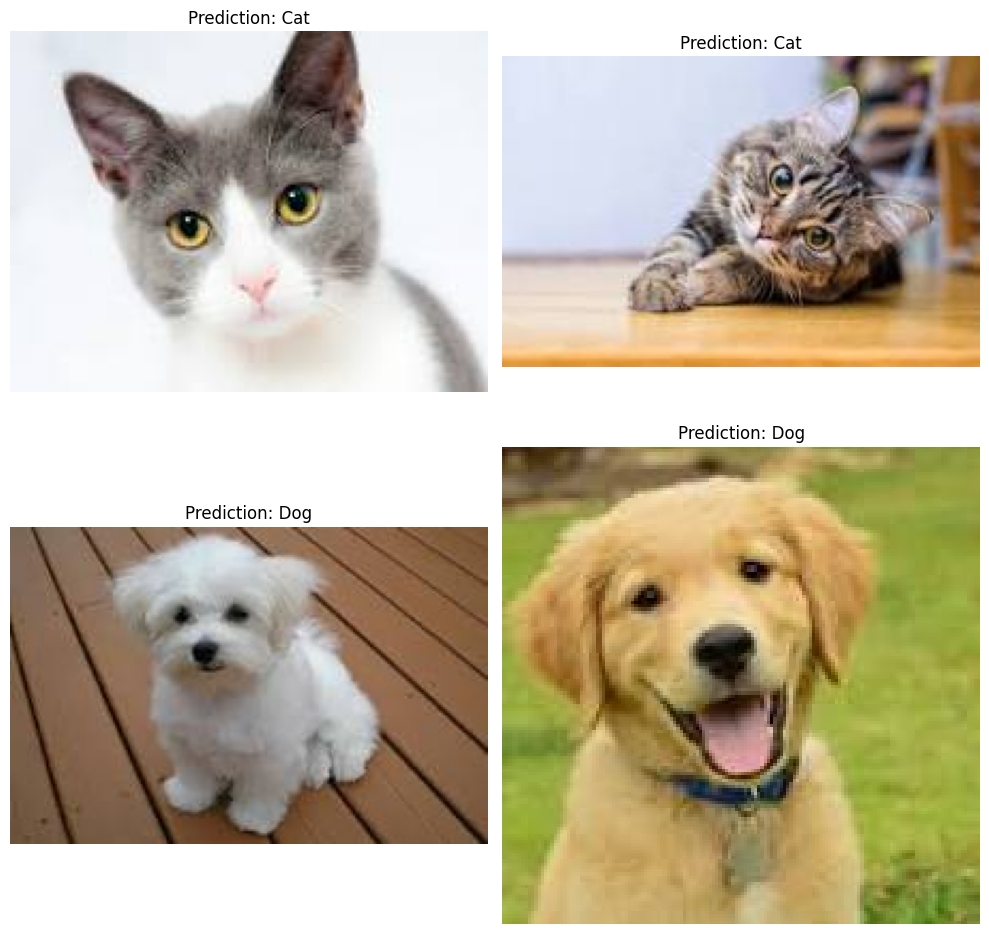

In [23]:
# Import TensorFlow library
import tensorflow as tf

# Train model
def train_model(model, train_generator, validation_generator):
    return model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // 32,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // 32,
        epochs=3
    )

# Save model as .h5 file
def save_model(model):
    model.save('dog_cat_classifier.h5')


# Load saved model
def load_saved_model():
    return tf.keras.models.load_model('dog_cat_classifier.h5')


# Main function
def main():
    base_model = load_base_model()
    freeze_base_model_layers(base_model)
    model = define_model(base_model)
    compile_model(model)
    history = train_model(model, train_generator, validation_generator)

    # Save model
    save_model(model)

    external_image_paths = [
        '/content/cat1.jpeg',
        '/content/cat2.jpeg',
        '/content/dog1.jpeg',
        '/content/dog2.jpeg'
    ]

    # Load saved model
    saved_model = load_saved_model()

    external_predictions = predict_external_images(saved_model, external_image_paths)

    # Display external images with predictions
    plt.figure(figsize=(10, 10))
    for i, image_path in enumerate(external_image_paths):
        img = load_img(image_path)
        plt.subplot(2, 2, i+1)
        plt.imshow(img)
        plt.title(f'Prediction: {external_predictions[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
